# Estimating Parameters in Network Models

Throughout Chapter 5, we spent a lot of attention developing intuition for many of the network models that are essential to understanding random networks. Recall that the notation that we use for a random network (more specifically, a network-valued random variable), $\mathbf A$, does *not* refer to any network we could ever hope to see (or as we introduced in the previous chapter, *realize*) in the real world. This issue is extremely important in network machine learning, so we will try to drive it home one more time: no matter how much data we collected (unless we could get infinite data, which we *can't*), we can never hope to understand the true distribution of $\mathbf A$. As network scientists, this leaves us with a bit of a problem: what, then, can we do to make useful claims about $\mathbf A$, if we can't actually see $\mathbf A$ nor its distribution?

This is where statistics, particularly, **estimation**, comes into play. At a very high level, estimation is a procedure to calculate properties about a random variable (or a set of random variables) using *only* the data we are given: finitely many (in network statistics, often just *one*) samples which we assume are *realizations* of the random variable we want to learn about. The properties of the random variable that we seek to learn about are called **estimands**, and  In the case of our network models, in particular, we will attempt to obtain reasonable estimates of the parameters (our *estimands*) associated with random networks.

Several key assumptions will be heavily used throughout the course of this chapter, which were developed in Chapter 5. In particular, the most common two properties we will leverage are:
1. Independence of edges: when working with independent-edge random network models, we will assume that edges in our random network are *independent*. This means that the probability of observing a particular realization of a random network is, in fact, the product of the probabilities of observing each edge in the random network. Notationally, what this means is that if $\mathbf A$ is a random network with $n$ nodes and edges $\mathbf a_{ij}$, and $A$ is a realization of that random network with edges $a_{ij}$, then:
\begin{align*}
    \mathbb P_\theta(\mathbf A = A) &= \mathbb P(\mathbf a_{11} = a_{11}, \mathbf a_{12} = a_{12}, ..., \mathbf a_{nn} = a_{nn}) \\
    &= \prod_{i, j} \mathbb P_\theta(\mathbf a_{ij} = a_{ij})
\end{align*}
In the special case where our networks are simple (undirected and loopless), this simplifies to:
\begin{align*}
    \mathbb P_\theta(\mathbf A = A) &= \prod_{i < j} \mathbb P_\theta(\mathbf a_{ij} = a_{ij})
\end{align*}
for any network realization $A$ which is simple. This is because if $\mathbf a_{ij} = a$, then we also know that $\mathbf a_{ji} = a$, and we only need to worry about one of the edges (we chose the edges in the upper right triangle of the adjacency matrix arbitrarily).  Further, since $A$ is also simple, then we know hat $\mathbf a_{ii} = 0$; that is, no nodes have loops, so we don't need to worry about the case where $i = j$ either.

## The Coin Flip Example

Let's think about what exactly this means using an example that you are likely familiar with. I have a single coin, and I want to know the probability of the outcome of a roll of that coin being a heads. For sake of argument, we will call this coin *fair*, which means that the true probability it lands on heads (or tails) is $0.5$. In this case, I would call the outcome of the $i^{th}$ coin flip the random variable $\mathbf x_i$, and it can produce realizations which take one of two possible values: a heads (an outcome of a $1$) or a tails (an outcome of a $0$). We will say that we see $10$ total coin flips. We will number these realizations as $x_i$, where $i$ goes from $1$ to $10$. To recap, the boldfaced $\mathbf x_i$ denotes the random variable, and the unbolded $x_i$ denotes the realization which we actually see. Our question of interest is: how do we estimate the probability of the coin landing on a heads, if we don't know anything about the true probability value $p$, other than the outcomes of the coin flips we got to observe?

Here, since $\mathbf x_i$ takes the value $1$ or $0$ each with probability $0.5$, we would say that $\mathbf x_i$ is a $Bernoulli(0.5)$ random variable. This means that the random variable $\mathbf x$ has the Bernoulli distribution, and the probability of a heads, $p$, is $0.5$. All $10$ of our $\mathbf x_i$ are called *identically distributed*, since they all have the same $Bernoulli(0.5)$ distribution.

We will also assume that the outcomes of the coin flips are mutually independent, which is explained in the terminology section.

For any one coin flip, the probability of observing the outcome $i$ is, by definition of the Bernoulli distribution:
\begin{align*}
    \mathbb P_\theta(\mathbf x_i = x_i) = p^{x_i} (1 - p)^{1 - x_i}
\end{align*}
Note that we use the notation $\mathbb P_\theta$ to indicate that the probability is a function of the parameter set $\theta$ for the random variable $\mathbf x_i$. Here, since the only parameter for each $\mathbf x_i$ is a probability $p$, then $\theta = p$.

If we saw $n$ total outcomes, the probability is, using the definition of mutual independence:
\begin{align*}
    \mathbb P_\theta(\mathbf x_1 = x_1, ..., \mathbf x_{n} = x_{n}; p) &= \prod_{i = 1}^{n}\mathbb P(\mathbf x_i = x_i) \\
    &= \prod_{i = 1}^n p^{x_i}(1 - p)^{1 - x_i} \\
    &= p^{\sum_{i = 1}^n x_i}(1 - p)^{n - \sum_{i = 1}^n x_i}
\end{align*}
What if we saw $10$ coin flips, and $6$ were heads? Can we take a "guess" at what $p$ might be? Intuitively your first reaction might be to say a good guess of $p$, which we will abbreviate $\hat p$, would be $0.6$, which is $6$ heads of $10$ outcomes. In many ways, this intuitive guess is spot on. However, in network machine learning, we like to be really specific about why, exactly, this guess makes sense. 

Looking at the above equation, one thing we can do is use the technique of **maximum likelihood estimation**. We call the function $\mathbb P(\mathbf x_1 = x_1, ..., \mathbf x_n = x_n; p)$ the *likelihood* of our sequence, for a given value of $p$. Note that we have added the term "$; p$" to our notation, which is simply to emphasize the dependence of the likelihood on the probability. So, what we *really* want to do is find the value that $p$ could take, which *maximizes* the likelihood. Let's see what the likelihood function looks like as a function of different values of $p$:

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

p = np.linspace(.02, .98, num=49)
nflips = 10; nheads = 6
likelihood = p**(nheads)*(1 - p)**(nflips - nheads)

fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x=p, y=likelihood, ax=ax)
ax.axvline(.6, color="red", linestyle="--")
ax.set(xlabel="Bernoulli probability parameter, p", ylabel="Likelihood, $P_{\\theta}(x_1, ..., x_{10})$")
ax;

As we can see, it turns out that our intuitive answer, that $p=0.6$, is in fact the Maximum Likelihood Estimate for the Bernoulli probability parameter $p$. Now how do we go about showing this rigorously?

An easier problem, we often will find, is to instead maximize the *log likelihood* rather than the likelihood itself. This is because the log function is *monotone*, which means that if $\mathbb P(\mathbf x_1 = x_1, ..., \mathbf x_n = x_n; p_1) < \mathbb P(\mathbf x_1 = x_1, ..., \mathbf x_n = x_n; p_2)$, then $\log\mathbb P(\mathbf x_1 = x_1, ..., \mathbf x_n = x_n; p_1) < \log \mathbb P(\mathbf x_1 = x_1, ..., \mathbf x_n = x_n; p_2)$ as well for some choices $p_1$ and $p_2$. Without going too down in the weeds, the idea is that the $\log$ function does not change any critical points of the likelihood. The log likelihood of the above expression is:
\begin{align*}
\log \mathbb P(\mathbf x_1 = x_1, ..., \mathbf x_{n} = x_{n}; p) &= \log \left[p^{\sum_{i = 1}^n x_i}(1 - p)^{n - \sum_{i = 1}^n x_i}\right] \\
&= \sum_{i = 1}^n x_i \log(p) + \left(n - \sum_{i = 1}^n x_i\right)\log(1 - p)
\end{align*}
And visually, the log-likelihood now looks instead like this:

In [ ]:
loglikelihood = nheads*np.log(p) + (nflips - nheads)*np.log(1 - p)


fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x=p, y=loglikelihood, ax=ax)
ax.axvline(.6, color="red", linestyle="--")
ax.set(xlabel="Bernoulli probability parameter, p", ylabel="Log Likelihood, $\\log P_{\\theta}(x_1, ..., x_{10})$")
ax;

Although we can see that the two plots look *almost* nothing alike, the key is the word *almost* here. Notice that the absolute maximum is, in fact, the same regardless of whether we use the likelihood or the log-likelihood. Further, notice that at the maximum, the slope of the tangent line is $0$. You may recall from calculus that this is how we typically go about finding a critical point of a function. Now, let's get make our argument a little more technical. Remembering from calculus $1$ and $2$, to find a maximal point of the log-likelihood function with respect to some variable $p$, our process looks like this:
1. Take the derivative of the log-likelihood with respect to $p$,
2. Set it equal to $0$ and solve for the critical point $p^*$,
3. Verify that the critical point $p^*$ is indeed an estimate of a maximum, $\hat p$. 

Proceeding using the result we derived above, and using the fact that $\frac{d}{du} \log(u) = \frac{1}{u}$ and that $\frac{d}{du} \log(1 - u) = -\frac{1}{1 - u}$:
\begin{align*}
\frac{d}{d p}\log \mathbb P(\mathbf x_1 = x_1, ..., \mathbf x_{n} = x_{n}; p) &= \frac{\sum_{i = 1}^n x_i}{p} - \frac{n - \sum_{i = 1}^n x_i}{1 - p} = 0 \\
\Rightarrow \frac{\sum_{i = 1}^n x_i}{p} &= \frac{n - \sum_{i = 1}^n x_i}{1 - p} \\
\Rightarrow (1 - p)\sum_{i = 1}^n x_i &= p\left(n - \sum_{i = 1}^n x_i\right) \\
\sum_{i = 1}^n x_i - p\sum_{i = 1}^n x_i &= pn - p\sum_{i = 1}^n x_i \\
\Rightarrow p^* &= \frac{1}{n}\sum_{i = 1}^n x_i
\end{align*}
We use the notation $p^*$ here to denote that $p^*$ is a critical point of the function.

Finally, we must check that this is an estimate of a maximum, which we can do by taking the second derivative and checking that the second derivative is negative. We will omit this since it's a bit intricate and tangential from our argument, but if you work it through, you will find that the second derivative is indeed negative at $p^*$. This means that $p^*$ is indeed an estimate of a maximum, which we would denote by $\hat p$.

Finally, using this result, we find that with $6$ heads in $10$ outcomes, we would obtain an estimate:
\begin{align*}
    \hat p &= \frac{6}{10} = 0.6
\end{align*}
which exactly aligns with our intuition.

So, why do we need estimation tools, if in our example, our intuition gave us the answer a whole lot faster? Unfortunately, the particular scenario we described was one of the *simplest possible examples* in which a parameter requires estimation. As the scenario grows more complicated, and *especially* when we extend to network-valued data, figuring out good ways to estimate parameters is extremely difficult. For this reason, we will describe some tools which are very relevant to network machine learning to learn about network parameters.

We will review estimation techniques for several of the approaches we discussed in Chapter 5, for Single Network Models.

## Erdös-Rényi (ER)

Recall that the Erdös-Rényi (ER) network has a single parameter: the probability of each edge existing, which we termed $p$. Due to the simplicity of a random network which is ER, fortunately we can resort to the Maximum Likelihood technique we delved into in the coin example above, and it turns out we obtain a very similar result with some caveats. In Chapter 5, we explored the derivation for the probability of observing a realization $A$ of a given random network $\mathbf A$ which is ER, which is equivalent to the likelihood of $A$. Recall this was:

\begin{align*}
    \mathbb P_\theta(A) &= p^{m} \cdot (1 - p)^{\binom{n}{2} - m}
\end{align*}

where $m = \sum_{i < j} a_{ij}$ is the total number of edges in the observed network $A$. Our approach here parallels directly the approach for the coin; we begin by taking the log of the probability:

\begin{align*}
    \log \mathbb P_\theta(A) &= \log \left[p^{m} \cdot (1 - p)^{\binom{n}{2} - m}\right] \\
    &= m \log p + \left(\binom n 2 - m\right)\log (1 - p)
\end{align*}

Next, we take the derivative with respect to $p$, set equal to $0$, and we end up with:
\begin{align*}
\frac{d}{d p}\log \mathbb P_\theta(A) &= \frac{m}{p} - \frac{\binom n 2 - m}{1 - p} = 0 \\
\Rightarrow p^* &= \frac{m}{\binom n 2}
\end{align*}
We omitted several detailed steps due to the fact that we show the rigorous derivation above. Checking the second derivative, which we omit since it is rather mathematically tedious, we see that the second derivative at $p^*$ is negative, so we indeed have found an estimate of the maximum, and will be denoted by $\hat p$. This gives that the Maximum Likelihood Estimate (or, the MLE, for short) of the probability $p$ for a random network $\mathbf A$ which is ER is:

\begin{align*}
    \hat p &= \frac{m}{\binom n 2}
\end{align*}

## *a priori* Stochastic Block Model

The *a priori* Stochastic Block Model also has a single paramter: the block matrix, $B$, whose entries $b_{kk'}$ denote the probabilities of edges existing or not existing between pairs of communities in the Stochastic Block Model. When we derived the probability for a realization $A$ of a random network $\mathbf A$ which could be characterized using the *a priori* Stochasic Block Model, we obtained that:
\begin{align*}
    \mathbb P_\theta(A) &= \prod_{k, k' \in [K]}b_{k'k}^{m_{k'k}} \cdot (1 - b_{k'k})^{n_{k'k - m_{k'k}}}
\end{align*}

where $n_{k'k} = \sum_{i < j}\mathbb 1_{\tau_i = k}\mathbb 1_{\tau_j = k'}$ was the number of possible edges between nodes in community $k$ and $k'$, and $m_{k'k} = \sum_{i < j}\mathbb 1_{\tau_i = k}\mathbb 1_{\tau_j = k'}a_{ij}$ was the number of edges in the realization $A$ between nodes within communities $k$ and $k'$. 

Noting that the log of the product is the sum of the logs, or that $\log \prod_i x_i = \sum_i \log x_i$, the log of the probability is:
\begin{align*}
    \log \mathbb P_\theta(A) &= \sum_{k, k' \in [K]} m_{k'k}\log b_{k'k} + \left(n_{k'k} - m_{k'k}\right)\log(1 - b_{k'k})
\end{align*}

We notice a side-note that we mentioned briefly in the network models section: in a lot of ways, the probability (and consequently, the log probability) of a random network which is an *a priori* SBM behaves very similarly to that of a random network which is ER, with the caveat that the probability term $p$, the total number of possible edges $\binom n 2$, and the total number of edges $m$ have been replaced with the probability term $b_{k'k}$, the total number of possible edges $n_{k'k}$, and the total number of edges $m_{k'k}$ which *apply only to that particular pair of communities*. In this sense, the *a priori* SBM is kind of like a collection of communities of ER networks. Pretty neat right? Well, it doesn't stop there. When we take the partial derivative of $\log \mathbb P_\theta(A)$ with respect to any of the probability terms $b_{l'l}$, we see an even more direct consequence of this observation:
\begin{align*}
    \frac{\partial }{\partial b_{l' l}}\log \mathbb P_\theta(A) &= \frac{\partial}{\partial b_{l'l}}\sum_{k, k' \in [K]} m_{k'k}\log b_{k'k} + \left(n_{k'k} - m_{k'k}\right)\log(1 - b_{k'k}) \\
    &= \sum_{k, k' \in [K]} \frac{\partial}{\partial b_{l'l}}\left[m_{k'k}\log b_{k'k} + \left(n_{k'k} - m_{k'k}\right)\log(1 - b_{k'k})\right]
\end{align*}
Now what? Notice that any of the summands in which $k \neq l$ and $k' \neq l'$, the partial derivative with respect to $b_{l'l}$ is in fact exactly $0$! Why is this? Well, let's consider a $k$ which is different from $l$, and a $k'$ which is different from $l'$. Notice that:
\begin{align*}
\frac{\partial}{\partial b_{l'l}}\left[m_{k'k}\log b_{k'k} + \left(n_{k'k} - m_{k'k}\right)\log(1 - b_{k'k})\right] = 0
\end{align*}
which simply follows since the quantity to the right of the partial derivative is not a funcion of $b_{l'l}$ at all! Therefore:
\begin{align*}
    \frac{\partial }{\partial b_{l' l}}\log \mathbb P_\theta(A) &= 0 + \frac{\partial}{\partial b_{l'l}}\left[m_{l'l}\log b_{l'l} + \left(n_{l'l} - m_{l'l}\right)\log(1 - b_{l'l})\right] \\
    &= \frac{m_{l'l}}{b_{l'l}} - \frac{n_{l'l} - m_{l'l}}{1 - b_{l'l}} = 0 \\
\Rightarrow b_{l'l}^* &= \frac{m_{l'l}}{n_{l'l}}
\end{align*}

Like above, we omit the second derivative test, and conclude that the MLE of the block matrix $B$ for a random network $\mathbf A$ which is *a priori* SBM is the matrix $\hat B$ with entries:
\begin{align*}
    \hat b_{l'l} &= \frac{m_{l'l}}{n_{l'l}}
\end{align*}

Let's work through an example network, with 20 nodes in each community, and a block matrix of:
\begin{align*}
    B &= \begin{bmatrix}
        .8 & .2 \\
        .2 & .8
    \end{bmatrix}
\end{align*}

Which corresponds to a probability matrix $P$ where each entry is:
\begin{align*}
    p_{ij} &= \begin{cases}
    0.8 & i, j \leq 20 \text{ or }i, j \geq 20 \\
    0.2 & \text{otherwise}
    \end{cases}
\end{align*}

We begin by simulating an appropriate SBM:

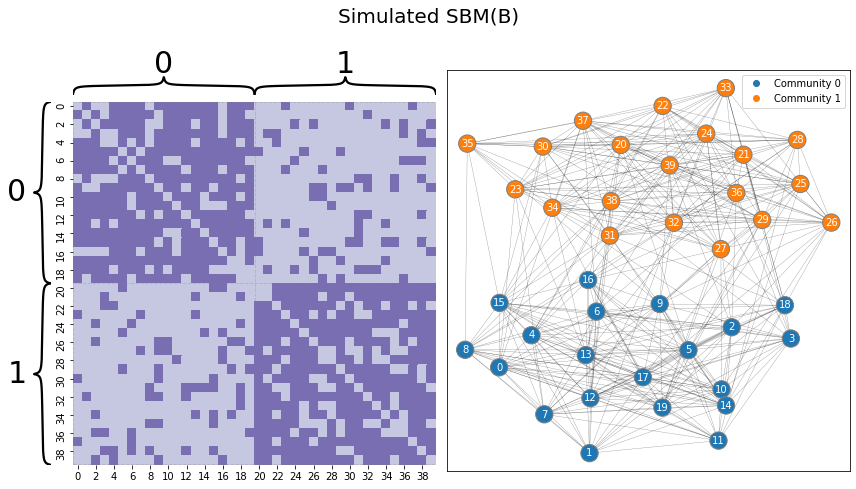

In [53]:
from graspologic.simulations import sbm
from graphbook_code import draw_multiplot

n = [20, 20]
B = [[.8, .2],
     [.2, .8]]

A = sbm(n=n, p=B)

y = [0 for i in range(0,n[0])] + [1 for i in range(0, n[1])]
draw_multiplot(A, labels=y, title="Simulated SBM(B)");

Next, let's fit an appropriate SBM, and investigate the estimate of $B$:

In [54]:
from graspologic.models import SBMEstimator
from graspologic.plot import heatmap
import matplotlib.pyplot as plt
import numpy as np

model = SBMEstimator(directed=False, loops=False)
model.fit(A, y=y)
Phat = model.p_mat_

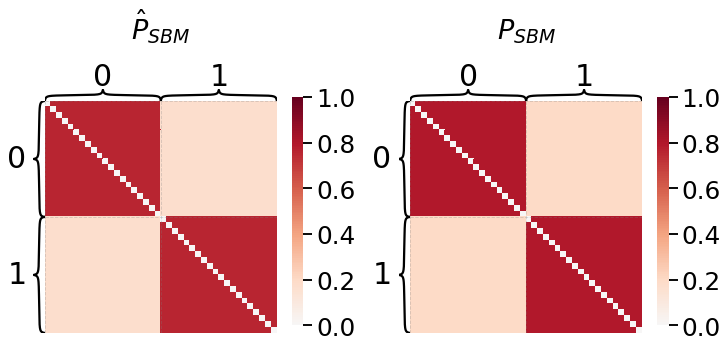

In [59]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

heatmap(Phat,
        inner_hier_labels=y,
        vmin=0,
        vmax=1,
        font_scale=1.5,
        title="$\hat P_{SBM}$",
        sort_nodes=True,
        ax=axs[0])

P = 0.2*np.ones((n[0] + n[1], n[0] + n[1]))  # default entries to 0.2
P[0:20,0:20] = 0.8  # B11
P[20:40,20:40] = 0.8  # B22
np.fill_diagonal(P, 0)  # loopless

heatmap(P,
        inner_hier_labels=y,
        vmin=0,
        vmax=1,
        font_scale=1.5,
        title="$P_{SBM}$",
        sort_nodes=True,
        ax=axs[1])

fig;

And our estimate $\hat P$ is very similar to the true probability matrix $P$.

## *a priori* Random Dot Product Graph

Next up, you might think intuitively we would jump to the *a posteriori* Stochastic Block Model, but as we will see in a second, estimation for an *a posteriori* Stochastic Block Model is, in fact, additional steps for a Random Dot Product Graph. The *a posteriori* Stochastic Block Model has a pair of parameters, the block matrix, $B$, and the community probability vector, $\vec \pi$. If you are keeping up with the log-likelihood derivations in the single network models section, you will recall that the log-likelihood for an *a posteriori* Stochastic Block Model, we obtain that:

\begin{align*}
    \mathbb P_\theta(A) &= \sum_{\vec \tau \in \mathcal T} \prod_{k = 1}^K \left[\pi_k^{n_k}\cdot \prod_{k'=1}^K b_{k' k}^{m_{k' k}}(1 - b_{k' k})^{n_{k' k} - m_{k' k}}\right]
\end{align*}

That expression, it turns out, is a lot more complicated than what we had to deal with for the *a priori* Stochastic Block Model. Taking the log gives us that:

\begin{align*}
\log 
    \mathbb P_\theta(A) &= \log\left(\sum_{\vec \tau \in \mathcal T} \prod_{k = 1}^K \left[\pi_k^{n_k}\cdot \prod_{k'=1}^K b_{k' k}^{m_{k' k}}(1 - b_{k' k})^{n_{k' k} - m_{k' k}}\right]\right)
\end{align*}

Whereas the log of a product of terms is the sum of the logs of the terms, no such easy simplification exists for the log of a sum of terms. This means that we will have to get a bit creative here. It is for this reason we begin by first discussing the Random Dot Product Graph.

The *a priori* Random Dot Product Graph has a single parameter, $X \in \mathbb R^{n \times d}$, which is a real matrix with $n$ rows (one for each node) and $d$ columns (one for each latent dimension). We estimate $X$ extremely simply for a realization $A$ of a random network $\pmb A$ which is characterized using the *a priori* Random Dot Product Graph.

In order to produce an estimate of $X$, we also need to know the number of latent dimensions of $\pmb A$. If we know the number of latent dimensions, we simply take $\hat X = \texttt{AdjacencySpectralEmbedding}(A, d)$, where $A$ is our realization of $\pmb A$ and $d$ are the number of latent positions of $\pmb A$. That is, we simply embed the adjacency matrix $A$ into $d$ dimensions, and the resulting matrix is our estimate of $X$!

Let's try an example of an *a priori* RDPG. We will use the same example that we used in the single network models section, where we defined the latent position matrix $X$ as follows. Let's assume that we have $60$ people who live along a very long road that is $20$ miles long, and each person is $\frac{1}{3}$ of a mile apart. The nodes of our network represent the people who live along our assumed street. If two people are closer to one another, it might make sense to think that they have a higher probability of being friends. If two people are neighbors, we think that they will have a very high probability of being friends (almost $1$) and when people are very far apart, we think that they will have a very low probability of being friends (almost $0$). We define $X$ to have rows given by:
\begin{align*}
    \vec x_i = \begin{bmatrix}
        \frac{60 - i}{60} \\
        \frac{i}{60}
    \end{bmatrix}
\end{align*}
Let's simulate an example network:

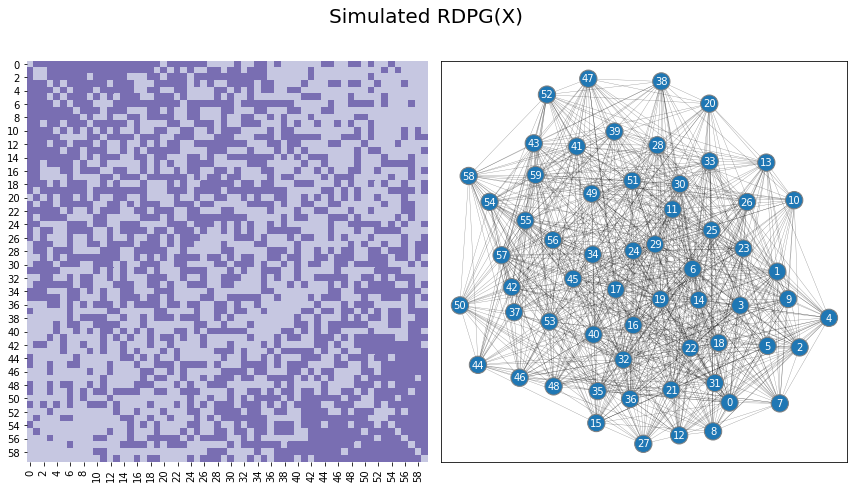

In [93]:
from graspologic.simulations import rdpg

n = 60  # the number of nodes in our network

# design the latent position matrix X according to 
# the rules we laid out previously
X = np.zeros((n,2))
for i in range(0, n):
    X[i,:] = [(n - i)/n, i/n]
    
P = X @ np.transpose(X)

A = rdpg(X)

draw_multiplot(A, title="Simulated RDPG(X)");

What happens when we fit a `rdpg` model to $A$?

In [94]:
from graspologic.models import RDPGEstimator

model = RDPGEstimator(loops=False)
model.fit(A)
Phat = model.p_mat_

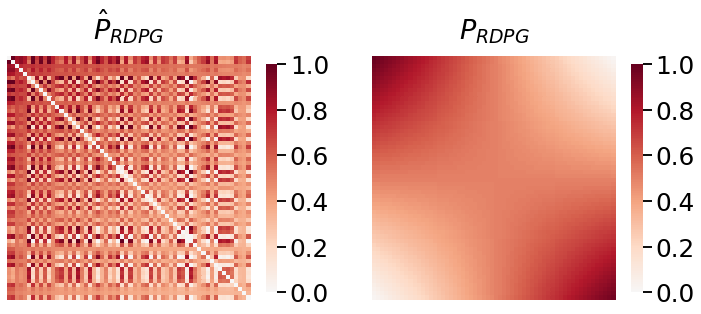

In [96]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

heatmap(Phat,
        vmin=0,
        vmax=1,
        font_scale=1.5,
        title="$\hat P_{RDPG}$",
        sort_nodes=True,
        ax=axs[0])

heatmap(P,
        vmin=0,
        vmax=1,
        font_scale=1.5,
        title="$P_{RDPG}$",
        sort_nodes=True,
        ax=axs[1])

fig;

1 yike for RDPG Estimator